# Data preparation
Takes the videos, both annotated and original ones and takes each frame apart for learning on individual images.

In [1]:
!git clone https://github.com/timurlenk07/onlab_duckietown -b data

Cloning into 'onlab_duckietown'...
remote: Enumerating objects: 613, done.
remote: Total 613 (delta 0), reused 0 (delta 0), pack-reused 613
Receiving objects: 100% (613/613), 2.41 GiB | 49.62 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Checking out files: 100% (110/110), done.


In [2]:
!mv onlab_duckietown/data data && rm onlab_duckietown -r

rm: cannot remove 'onlab_duckietown': Is a directory


In [1]:
# import required libraries
import cv2
import os
import glob
import logging
import concurrent.futures
import numpy as np
import keras

# Set random seeds
np.random.seed(2019)
from tensorflow import set_random_seed
set_random_seed(1118)

keras.__version__

Using TensorFlow backend.


ImportError: cannot import name 'set_random_seed'

The below code iterates through all the videos in a directory and cuts them into single images. To fasten up this process multithreading was applied.

In [5]:
logging.basicConfig(level=logging.INFO, format='[%(levelname)s]: %(message)s')

train_dir = os.path.join(os.getcwd(), 'data', "train")
valid_dir = os.path.join(os.getcwd(), 'data', "validation")
test_dir = os.path.join(os.getcwd(), 'data', "test")
dirs = [train_dir, valid_dir, test_dir]

new_res = (160, 120)

def video2images(directory):
    logging.info(f"Managing directory: {directory}")

    # Get the list of available recordings
    annot_vids = sorted(glob.glob(os.path.join(directory, '*_annot_pp.avi')))
    orig_vids = sorted(glob.glob(os.path.join(directory, '*_orig_pp.avi')))

    # Check whether original and annotated recordings number match or not
    assert len(annot_vids) == len(orig_vids)
    
    logging.info(f"{directory} Number of files found: {len(annot_vids)}. Taking apart video files...")

    os.makedirs(os.path.join(directory, 'orig'))
    os.makedirs(os.path.join(directory, 'annot'))

    img_counter = 0
    vid_counter = 0
    # Iterate and postprocess every recording
    for vid_a, vid_o in zip(annot_vids, orig_vids):

        # Open recordings...
        cap_orig = cv2.VideoCapture(vid_o)
        cap_annot = cv2.VideoCapture(vid_a)
        if not cap_orig.isOpened() or not cap_annot.isOpened():
            logging.warning(f"{directory} Could not open file nr. {vid_counter}! Continuing...", )
            continue
        
        # Check whether recordings hold the same number of frames
        if cap_orig.get(cv2.CAP_PROP_FRAME_COUNT) != cap_annot.get(cv2.CAP_PROP_FRAME_COUNT):
            logging.warning(f"{directory} Different video length encountered in video nr. {vid_counter}! Continuing...")
            continue
        
        
        # Produce output videos
        logging.debug(f"{directory} Processing recording nr. {vid_counter}...")
        while cap_orig.isOpened() and cap_annot.isOpened(): # Iterate through every frame
            ret_o, frame_o = cap_orig.read()
            ret_a, frame_a = cap_annot.read()
            if not ret_o or not ret_a:
                break

            frame_o = cv2.resize(frame_o, new_res)
            frame_a = cv2.cvtColor(frame_a, cv2.COLOR_BGR2GRAY)
            frame_a = cv2.resize(frame_a, new_res)

            filename = str(img_counter).zfill(6) + '.png'
            filepath_o = os.path.join(directory, 'orig', filename)
            filepath_a = os.path.join(directory, 'annot', filename)
            # Save both frames in new file
            cv2.imwrite(filepath_o, frame_o)
            cv2.imwrite(filepath_a, frame_a)

            img_counter += 1

        
        logging.debug(f"{directory} Processing of recording nr. {vid_counter} done.")
        vid_counter += 1
        
        # Release VideoCapture resources
        cap_orig.release()
        cap_annot.release()

        os.remove(vid_a)
        os.remove(vid_o)

    logging.info(f"{directory} Video files taken apart! Images generated: {img_counter}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures_of_images = [executor.submit(video2images, directory) for directory in dirs]
    
    concurrent.futures.wait(futures_of_images)

[INFO]: Managing directory: /content/data/train
[INFO]: /content/data/train Number of files found: 33. Taking apart video files...
[INFO]: Managing directory: /content/data/validation
[INFO]: /content/data/validation Number of files found: 11. Taking apart video files...
[INFO]: Managing directory: /content/data/test
[INFO]: /content/data/test Number of files found: 11. Taking apart video files...
[INFO]: /content/data/test Video files taken apart! Images generated: 1178
[INFO]: /content/data/validation Video files taken apart! Images generated: 1963
[INFO]: /content/data/train Video files taken apart! Images generated: 5352


Set variables for easier data access in later code.

In [6]:
train_x_dir = os.path.join(train_dir, 'orig')
train_y_dir = os.path.join(train_dir, 'annot')
valid_x_dir = os.path.join(valid_dir, 'orig')
valid_y_dir = os.path.join(valid_dir, 'annot')
test_x_dir = os.path.join(test_dir, 'orig')
test_y_dir = os.path.join(test_dir, 'annot')

train_cnt = len(glob.glob(os.path.join(train_x_dir, '*.png')))
valid_cnt = len(glob.glob(os.path.join(valid_x_dir, '*.png')))
test_cnt = len(glob.glob(os.path.join(test_x_dir, '*.png')))

assert train_cnt == len(glob.glob(os.path.join(train_y_dir, '*.png')))
assert valid_cnt == len(glob.glob(os.path.join(valid_y_dir, '*.png')))
assert test_cnt == len(glob.glob(os.path.join(test_y_dir, '*.png')))

print(f"Train set count: {train_cnt}")
print(f"Valid set count: {valid_cnt}")
print(f"Test set count: {test_cnt}")

Train set count: 5352
Valid set count: 1963
Test set count: 1178


# Model creation and training
We define custom generators to create batches of learning data. Then we will create our model and initialize all necessary callbacks for efficient learning. Then we fit our generators until stop conditions are satisfied.

In [1]:
def data_generator(batch_size, total_count, inputs_dir, outputs_dir):
    while True:
        # read batch size random indexed images
        t_idxs = np.random.randint(0, total_count, batch_size)
        x_shape = (batch_size, 120, 160, 3)
        y_shape = (batch_size, 120, 160)
        x = np.zeros(shape=x_shape, dtype=np.float32)
        y = np.zeros(shape=y_shape, dtype=np.float32)

        for i, idx in enumerate(t_idxs):
            filename = f'{idx:06d}.png'
            x[i] = cv2.imread(os.path.join(inputs_dir, filename))
            y[i] = cv2.imread(os.path.join(outputs_dir, filename), cv2.IMREAD_GRAYSCALE) 
        
        yield (x/255,y/255)

steps_per_epoch = 200
train_batch_size = int(train_cnt / steps_per_epoch)
valid_batch_size = int(valid_cnt / steps_per_epoch)
test_batch_size = int(test_cnt / steps_per_epoch)
train_gen = data_generator(train_batch_size, train_cnt, train_x_dir, train_y_dir)
valid_gen = data_generator(valid_batch_size, valid_cnt, valid_x_dir, valid_y_dir)
test_gen = data_generator(test_batch_size, test_cnt, test_x_dir, test_y_dir)

NameError: name 'train_cnt' is not defined

Our model consists of an encoder half-network that is followed by a decoder half-network, with sigmoid activation applied to the combined output of the last decoder layer.

In [0]:
kernel_size = (6,8)
filters = 64

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(120, 160, 3)))    # RGB image goes in

# ENCODER
# --------------------
for _ in range(3):
    for _ in range(2):
        model.add(keras.layers.Conv2D(filters=filters,
                                        kernel_size=kernel_size,
                                        strides=1,
                                        padding='same',
                                        use_bias=True,
                                        bias_initializer=keras.initializers.constant(value=0.0)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())

    model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
    filters *= 2
# --------------------

# DECODER
# --------------------
for _ in range(3):
    filters = round(filters/2)
    model.add(keras.layers.UpSampling2D(size=2,
                                        interpolation='nearest'))
    for _ in range(2):
        model.add(keras.layers.Conv2D(filters=filters,
                                        kernel_size=kernel_size,
                                        strides=1,
                                        padding='same',
                                        use_bias=True,
                                        bias_initializer=keras.initializers.constant(value=0.0)))
        model.add(keras.layers.BatchNormalization())       
        model.add(keras.layers.ReLU())
# --------------------

model.add(keras.layers.Dense(units=1,
                                activation='sigmoid',
                                use_bias=True
))
model.add(keras.layers.Reshape((120,160)))

In [14]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss="binary_crossentropy", metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 120, 160, 64)      9280      
_________________________________________________________________
batch_normalization_13 (Batc (None, 120, 160, 64)      256       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 120, 160, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 120, 160, 64)      196672    
_________________________________________________________________
batch_normalization_14 (Batc (None, 120, 160, 64)      256       
_________________________________________________________________
re_lu_14 (ReLU)              (None, 120, 160, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 60, 80, 64)       

As we see we have about 15M parameters and practically all of them are up for training. Now we should define our callbacks.

In [0]:
checkpoint_name = 'rightlane_segment.hdf5'
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_name,
                                                          monitor='val_loss',
                                                          verbose=1,
                                                          save_weights_only=True,
                                                          save_best_only=True)

callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10, verbose=1)
callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          patience=7,
                                                          verbose=1,
                                                          min_rl=1e-5)

We are ready for training! We apply our generator functions to the fit_generator function of our model.

In [16]:
model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=steps_per_epoch,
    callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping]
)

Epoch 1/50
200/200 [==============================] - 122s 611ms/step - loss: 0.2416 - acc: 0.8930 - val_loss: 0.1682 - val_acc: 0.9318

Epoch 00001: val_loss improved from inf to 0.16824, saving model to rightlane_segment.hdf5
Epoch 2/50
200/200 [==============================] - 116s 582ms/step - loss: 0.0802 - acc: 0.9675 - val_loss: 0.1029 - val_acc: 0.9578

Epoch 00002: val_loss improved from 0.16824 to 0.10291, saving model to rightlane_segment.hdf5
Epoch 3/50
200/200 [==============================] - 116s 582ms/step - loss: 0.0620 - acc: 0.9739 - val_loss: 0.0911 - val_acc: 0.9639

Epoch 00003: val_loss improved from 0.10291 to 0.09111, saving model to rightlane_segment.hdf5
Epoch 4/50
200/200 [==============================] - 116s 581ms/step - loss: 0.0401 - acc: 0.9817 - val_loss: 0.0739 - val_acc: 0.9697

Epoch 00004: val_loss improved from 0.09111 to 0.07394, saving model to rightlane_segment.hdf5
Epoch 5/50
200/200 [==============================] - 116s 582ms/step - loss

It looks as our model was able to learn and since we are satisfied with the resultant metrics we will reload our last checkpoint.

In [0]:
# load best model
try:
    model.load_weights(checkpoint_name)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

# Evaluation
We will take a couple of samples from test data and evaluate our algorithm on those unseen pictures. This will allow us to analize the generalization of our model.

In [0]:
from google.colab.patches import cv2_imshow

def predict(num):
    x, y = next(test_gen)
    x = x[:num]
    y = y[:num]
    p = [model.predict(np.expand_dims(x[i], axis=0))[0] for i in range(len(x))]
    for r in range(len(x)):
        a = np.array(x[r])*255
        b = np.zeros(shape=x[r].shape)
        c = np.zeros(shape=x[r].shape)
        for i in range(120):
            for j in range(160):
                b[i,j,0] = y[r][i,j]
                b[i,j,1] = y[r][i,j]
                b[i,j,2] = y[r][i,j]
                c[i,j,0] = p[r][i,j]
                c[i,j,1] = p[r][i,j]
                c[i,j,2] = p[r][i,j]
        b = b*255
        c = c*255
        img = np.concatenate((a, b, c), axis=1)
        cv2_imshow(img)

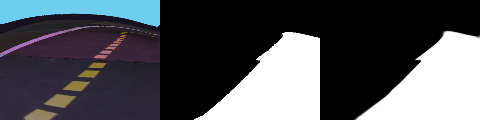

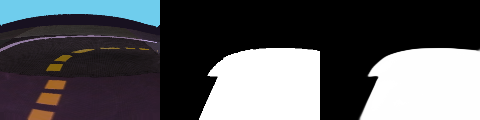

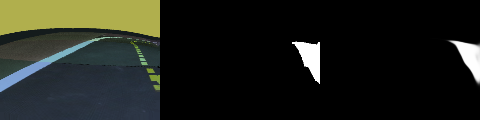

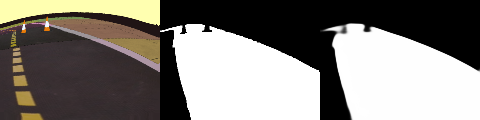

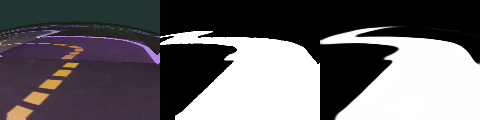

In [20]:
predict(5)

It looks as our model was able to predict quite correctly the right lane in the simulated environment. Some noises appear at some point but overall the accuracy is adequate.